Investigate the effect of school status on smartwatch wear rate

In [1]:
%load_ext autoreload
%autoreload 2

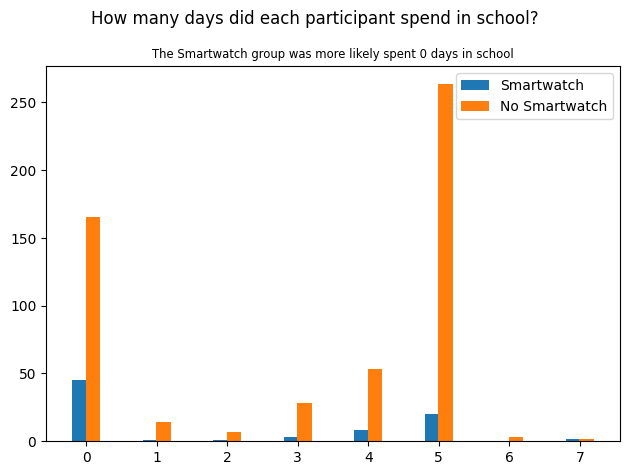

In [43]:
"""
Make a histogram of how many days each participant spent in school

"""
import numpy as np
import matplotlib.pyplot as plt

from ema import read

schooldays_with_watch = read.n_days_in_school(subset="smartwatch")
schooldays_no_watch = read.n_days_in_school(subset="not smartwatch")

fig, axis = plt.subplots()
bins1 = np.sort(np.concatenate([np.arange(8) - 0.2, np.arange(8) + 0.01]))
bins2 = np.sort(np.concatenate([np.arange(8) - 0.01, np.arange(8) + 0.2]))
axis.hist(schooldays_with_watch.values(), bins=bins1, label="Smartwatch")
axis.hist(schooldays_no_watch.values(), bins=bins2, label="No Smartwatch")

fig.suptitle("How many days did each participant spend in school?")
axis.set_title(
    "The Smartwatch group was more likely spent 0 days in school", fontsize="small"
)
axis.legend()

fig.tight_layout()

fig.savefig("img/schooldays.png")

Text(0.5, 1.0, 'Smartwatch Only')

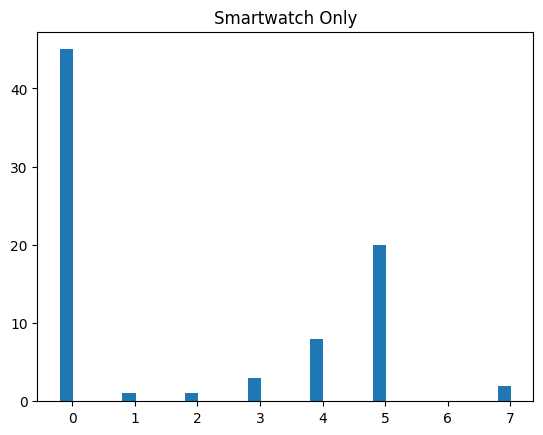

In [45]:
plt.hist(schooldays_with_watch.values(), bins=bins1)
plt.title("Smartwatch Only")

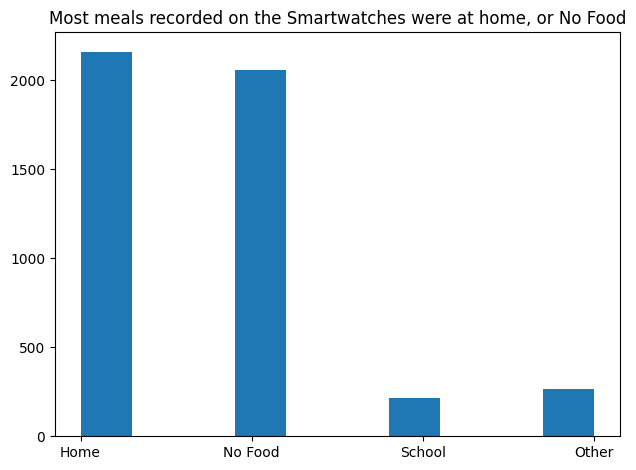

In [55]:
"""
Find what proportion of entries were at home/school/other, overall and as a function of how many days spent in school

"""
from ema import clean

meal_types = {"Meal", "Drink", "Snack", "No food/drink"}
meal_info = clean.cleaned_smartwatch(keep_catchups=False)

plt.hist(meal_info[meal_info["meal_type"].isin(meal_types)]["location"])

plt.xticks(plt.gca().get_xticks(), ["Home", "No Food", "School", "Other"])

plt.title("Most meals recorded on the Smartwatches were at home, or No Food")

plt.tight_layout()